### NOTE: run the last cell first!

## Q-Value learning

Last time we showed methods for _evaluating_ $V_{\pi} (s) $. 
Today we will recycle most of the ideas from the past excercise for the application of _model-free control_, i.e. to find the optimal policy given only the experience of an environment. Again, the experience consists in the trajectories we perform as we explore the environment:

$\tau_i = (S^i_0, A^i_0, R^i_1, S^i_1, A^i_1, R^i_1, \dots S^i_{T^i})$


To do this, it will be more convenient to consider, instead of the _state_-function $V_{\pi} (s) $, the _state/action_-function $Q_{\pi}(s,a)$. It is defined as:

### Definition 1.

$$
Q_{\pi}(s,a) = \mathbb{E}_\pi\bigg[ \sum_{t=0}^\infty \gamma^t \, R_{t+1} \, \, \Big| \, \, S_0 = s, A_0 = a \bigg] \ .
$$

_"The expectation discounted cumulative sum of all future rewards when starting from state $s$, acting with action $a$ and then always following the policy $\pi$"_

or equivalently as:

### Formulation 2.

$$
Q_\pi(s,a) = \mathbb{E}_{\pi}\bigg[ R_1 + \gamma V_\pi(S_1) \,\, \Big| \,\, S_0 = s, A_0 = a\bigg] \ .
$$

_"The expectation value of the immediate reward plus the discounted $V$-value of the following state $S_1$, when starting from state $s$, acting with action $a$ and then always following the policy $\pi$."_

or again as:

### Formulation 3.

$$
Q_\pi(s,a) = \mathbb{E}_{\pi}\bigg[ R_1 + \gamma  \, \sum_{a'} \, Q_\pi(S_1, a') \, \pi(a' | S_1) \,\, \Big| \,\, S_0 = s, A_0 = a\bigg] \ .
$$
_"The expectation value of the immediate reward plus the discounted $Q$-value of the following state $S_1$ and all possible actions $a'$ weighted by the probability of taking that action ($\pi(a' | S_1)$), when starting from state $s$, acting with action $a$ and then always following the policy $\pi$."_


## First, only evaluation of Q

Let us "recast" the evaluation class from last time, when we where learning the value function $V_{\pi}(s)$ into the evaluation of the Quality function $Q_{\pi}(s,a)$ using the third formulation.


In [2]:
class Q_Evaluation():
    def __init__(self, 
                 space_size,    # i.e. the (Ly, Lx) of the gridworld
                 action_size,   # i.e. how many actions are possible
                 policy,        # i.e. the policy to be evaluated, as an array
                 gamma=1,       # i.e. the discount factor
                 lr_v=0.01):    # i.e. the learning rate
        """
        Evaluates Q-value for (S,A) pairs, using one-step updates.        
        """
        
        # the discount factor
        self.gamma = gamma
        # size of system
        self.space_size = space_size # as tuple
        self.action_size = action_size 

        # policy to evaluate
        self.policy = policy
        
        # the learning rate
        self.lr_v = lr_v
        
        # where to save returns
        self.Qvalues = np.zeros( (*self.space_size, self.action_size) )
    
        # ------ ALERT! -------
        # SMALL TECHNICAL NOTE: puttin an asterix before a list/array/tuple A, i.e. *A
        # unpacks its values.
        # For example if self.size = (3,2) and self.action_size is 4 
        # then  (*self.size, self.action_size) = (3,2,4)
        # Also if s is an array [3,2] 
        # (*s,) = (3,2)
        
    
    # -------------------   
    def single_step_update(self, s, a, r, new_s, done):
        """
        Uses a single step to update the values.
        """
        
        # Indexing should be a tuple
        # index state/action = (*s, a)
        # index new_state/action = (*new_s, a)
        
        if done:
            # in TD(0) it was
            # delta = (r + 0 - self.values[s])
            
            # CODE HERE !
            deltaQ = (r + 0 - self.Qvalues[ (*s, a) ])
        else:
            # in TD(0) it was
            # delta = (r + gamma*self.values[new_s] - self.values[s])

            # CODE HERE !
            deltaQ = ( r + 
                            # np.dot(A,B) = sum_i A_i*B_i
                      self.gamma * np.dot( self.Qvalues[ (*new_s,) ], self.policy[ (*new_s,) ] ) 
                                                                - self.Qvalues[ (*s,a) ] )
            # Notice that I calculate the expected Qvalue in new_s over all possibilities!            

        self.Qvalues[ (*s, a)] += self.lr_v * deltaQ
        
    # ---------------------
    def get_action_from_policy(self, s):
        """
        Select one action with probabilities defined by the policy to evaluate.
        """
        a = np.random.choice(self.action_size, p=self.policy[ (*s,) ])
        return a

## Gridworld again!

Moving in a gridworl where you can fall off a cliff.

- **Transitions:** I can move left, right, up, down (but not off the board). If I fall over the cliff I get trasported back to the beginning (but the episode does not end). 

- **Rewards:** All steps have a $-1$ penalty (I want the path to be the shortest possible!). If I fall over the cliff, I get $-100$.

- **End of Episode.** The episode ends only when I reach the end goal.

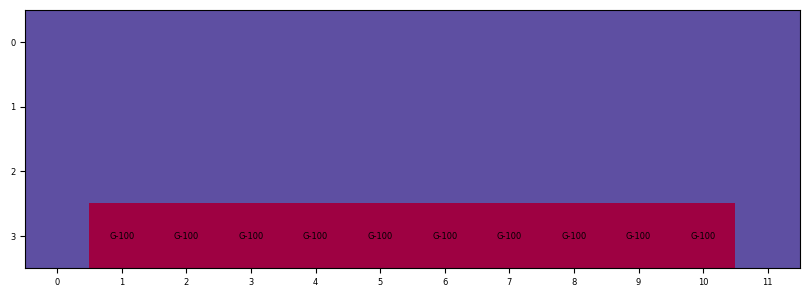

In [3]:
import numpy as np
# RECREATE THE WORLD AS IN SUTTON&BARTO EX.6.6

Lx = 12
Ly = 4


goal = [(3, i) for i in range(1,11)]
rewards = [-100 for i in range(1,11)]

def new_world(Lx, Ly, goal, rewards):
    assert len(goal) == len(rewards)
    World = np.zeros((Ly,Lx))
    for g, r in zip(goal, rewards):
        World[g] = r
    return World

World = new_world(Lx, Ly, goal, rewards)

plot_world(World)


## The Gridworld environment (again).

Now the GridWorld is in the form of a class, which we will use as a "black-box".
The important thing about it is that how it interacts with the agent, which is through the functions:

- init(World, start, end): creates the gridworld using the matrix World. It has a starting position "start" and a final terminal state in "end".
- reset(): reset the state to the starting position, and reset done to False
- step(A): the main function of the environment. Takes an action as input (must be one of these: [[1,0],[0,1],[-1,0],[0,-1]]), and returns _S_new, reward, self.done_
- render(): does nothing, I just put it there for consistency with "typical" environment.


In [4]:
class GridWorldEnv():
    def __init__(self, World, start, end):
        """
        Defines a GridWorld with start and end sites.
        """
        # Reads the World shape
        self.Ly, self.Lx = World.shape
        self.World = World
        
        # Reads the position of start and end
        self.start = start
        self.end = end
        
        # Keeps track of current state
        self.current_state = self.start
        
        # Keeps track of terminal state
        self.done = False
        
    def reset(self):
        """
        Resets the GridWorld to the starting position.
        """
        # Reset the environment to initial state
        self.current_state = self.start
        self.done = False
        
    def step(self, A):
        """
        Evolves the environment given action A and current state.
        """
        # Check if action A is in proper set
        assert A in np.array([[1,0],[0,1],[-1,0],[0,-1]])
        S = self.current_state
        S_new = S + A

        
        # Always a penalty for moving -> want to find the shortest path!
        reward = -1

        # If I go out of the world, I stay still
        if ( ((S_new[0] == self.Ly) or np.any(S_new == -1)) or (S_new[1] == self.Lx)):
            S_new = S
        # If I fall over the ridge, I go back to the start and get a penalty
        elif self.World[ (*S_new,) ] < 0:
            reward = self.World[ (*S_new,) ]
            S_new = self.start
        elif np.all(S_new == self.end):
            self.done = True         
        
        # Save in memory new position
        self.current_state = S_new
            
        return S_new, reward, self.done
        
        
    def render(self):
        """
        Does nothing.
        """
        pass

# Let us evaluate a simple policy.

Which policy?
Let us do a very simple policy which is _the same for all states_. We want to avoid the cliff, so let us do something which goes up a bit more than down, and only. Something like this:

$$
    \pi(s) = \left\{
    \begin{array}{clll}
        & \text{left}  \,\,\,& w.p. \,\, 0.2 \\[2ex]
        & \text{right} \,\,\,& w.p. \,\, 0.3 \\[2ex]
        & \text{up}    \,\,\,& w.p. \,\, 0.45 \\[2ex]
        & \text{down}  \,\,\,& w.p. \,\, 0.25 \\[2ex]
\end{array}
    \right.
$$

Why? Just to check everything works :)


In [5]:

# ---------------------------------------
# The list of actions I can take: 
#Actions =           [Down,   Up,  Right,Left]
Actions  = np.array([[1,0],[-1,0],[0,1],[0,-1]])

# ---------------------------------------
# state/action space =         [  Lx * Ly, 4]
policy = np.zeros( (4,12,4) )
policy[:,:] = [0.2, 0.3, 0.45, 0.05]

# set environment!-----------------------
# ----------------- Start   End

env = GridWorldEnv(World, start=[3,0], end=[3,11])

# ---------------------------------------
# gamma
gamma = 1.0

# learning rate
lr_v = 0.1

Qvalues for action 0 = Down


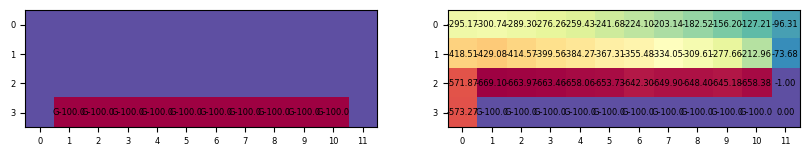

Qvalues for action 1 = Up


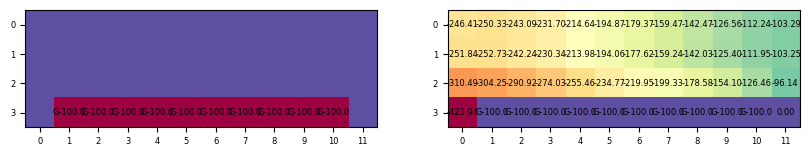

Qvalues for action 2 = Right


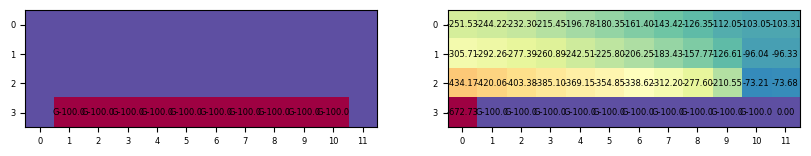

Qvalues for action 3 = Left


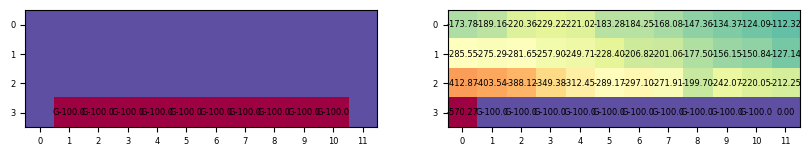

In [6]:
# TRAJECTORIES AND VALUE EVALUATION

n_episodes = 1000

# Initialize 
QEval = Q_Evaluation(space_size=World.shape, action_size=4, policy=policy, gamma=gamma, lr_v=0.1)

# RUN OVER EPISODES
for i in range(n_episodes):
    done = False

    env.reset()
    s = env.current_state
    a = QEval.get_action_from_policy(s)
    act = Actions[a]
    while not done:
        new_s, r, done = env.step(act)
        QEval.single_step_update(s, a, r, new_s, done)
        a = QEval.get_action_from_policy(new_s)
        act = Actions[a]
        s = new_s


Qvalues = QEval.Qvalues

print('Qvalues for action 0 = Down')
plot_world_values(World, Qvalues[:,:,0])
print('Qvalues for action 1 = Up')
plot_world_values(World, Qvalues[:,:,1])
print('Qvalues for action 2 = Right')
plot_world_values(World, Qvalues[:,:,2])
print('Qvalues for action 3 = Left')
plot_world_values(World, Qvalues[:,:,3])

# TD Control with the $Q$-value function:

TD-Control with $Q$-value function is very convenient, because ideally once one has calculated the optimal value $Q^*(s,a)$, the optimal policy is easily found just by taking the action that maximizes it. 


Recall the _Bellman's optimality eq_.

$$
Q^*(s,a) = \sum_{s'} p(s' | s,a) \, \big( r(s,a,s') + \gamma \text{max}_{a'} \, Q^*(s',a') \big)
$$

Then the _optimal policy_ $\pi^*(a|s)$ is just _the action that maximize the state/action value_.

$$
\pi^*(a|s) = \text{argmax}_a Q^*(s,a)
$$



Since the optimal value however is unknown, the strategy is to **work iteratively**. 

- 0) Make a guess $\hat{Q}_0(s,a)$ 
- 1) _Create a policy_ $\pi_0(a|s)$ using the current evaluation $\hat{Q}_0(s,a)$
- 2) _Estimate_ $\hat{Q}_1(s,a)$ from the current policy
- 3) Create a policy $\pi_1(a|s)$ using the current evaluation $\hat{Q}_1(s,a)$
- 4) Go back to 1) again until convergence

...

- N) Approximate $Q^* = \hat{Q}_N$ and $\pi^* = \text{argmax}_a \hat{Q}_N$

All algorithms that we will see today belong to the same "ideal structure" as above!
The main differences will be in how to **estimate the $Q^*$** function. (As in $V$-value evaluation!).

## Explore & Exploit.

In value evaluation, we were *given* a policy to evaluate.
Here, the aim is to *find* the optimal policy $\pi^*$.

While the optimal policy is "trivial" when we have perfect information of the $Q$-value function, how to *achieve that* is not an immediate task.

The policy we have to create to experience trajectories from the environment needs to balance two opposite drives:

- **Exploitation**: Acting optimally _given the current information available_. This amounts to do at time $t$ the best action selected by $A_t = \text{argmax}_a Q_t(S_t, a)$. This will increase the possibility to achieve better rewards. (But the current information could be wrong...)


- **Exploration**: Do actions that are sub-optimal _given the current information available_. These _could_ lead to un-explored states with even better rewards than what experienced so far. (But if th current information is perfect... This will always be sub-optimal!)



#### (The Ice-Cream example.
- **Exploitation**: I have tried only watermelon and lemon. I prefer watermelon: I will always choose that for the rest of my life (what about chocolate?????).
- **Exploration**: I know that I love chocolate, but I always take a different flavor when I buy an ice-cream. I have tasted nuts, melon, mint, strawberry, white-chocolate, pistachios, tiramisù, gorgonzola, peach... I still prefer chocolate. )


## $\epsilon$-greedy policies.

One simple way to achieve some exploration/exploitation balance is to use so-called $\epsilon$-greedy policies. $\epsilon$ is a (small) number between $0$ and $1$. With probability $1-\epsilon$, the action is _greedy_ w.r.t. the current information (=exploitation). But with probability $\epsilon$ the action is completly random over _all_ possible actions (=exploration).

$$
    \pi^{\epsilon}(s) = \left\{
    \begin{array}{cll}
        & \text{argmax}_a \hat{Q}(s, a)   & \text{if} \,\,\,\, w.p. 1-\epsilon\\[2ex]
        & \text{any}\,\,\, a   & \text{if} \,\,\,\, w.p. \epsilon \\[2ex]
    \end{array}
    \right.
$$

$\epsilon$-greedy policies are very well known and studied, but have a problem. Even at convergence, they perform sub-optimally with probability $\epsilon$! So In the long run they are _too explorative_! One solution is to make $\epsilon$ a function of time.


##  SARSA: on-policy TD Control

SARSA is a very straightforward method. It consists at its core in two elements:

- A way to update the current estimation of the $Q$-value ($\hat{Q}_{t}$), given the immediately past experience: the TD(0) error $\delta_Q$
$$
\hat{Q}_{t+1} = \hat{Q}_{t} + \alpha \delta_Q
$$

- A way to construct a ($\epsilon$-greedy) policy $\pi_t^{\epsilon}(s)$ given the current evaluation $\hat{Q}_t(s)$.

We will use the $\epsilon$-greedy function defined as:

$$
    \pi_t^{\epsilon}(s) = \left\{
    \begin{array}{cll}
        & \text{argmax}_a \hat{Q}_t(s, a)   & \text{if} \,\,\,\, w.p. 1-\epsilon\\[2ex]
        & \text{any}\,\,\, a   & \text{if} \,\,\,\, w.p. \epsilon \\[2ex]
    \end{array}
    \right.
$$

### What does SARSA need?
At every step $t$, we will use:

- the past state $S_t$ (S)
- the past action $A_t$ (A) (following the $\epsilon$-greedy policy)
- the new reward $R_{t+1}$ (R)
- the new state $S_{t+1}$ (S')
- the new action $A_{t+1}$ (A') (following the $\epsilon$-greedy policy)

($\rightarrow$ SARSA!)

and will calculated the update as a Temporal Difference error TD(0).

$$
\delta_Q = R_{t+1} + \gamma \,\, \hat{Q}_t(S_{t+1}, A_{t+1}) - \hat{Q}_t(S_{t}, A_t)
$$

(Compare it with $V$-value as in last lecture: $\delta = R_{t+1} + \gamma \,\, \hat{V}_t(S_{t+1}) - \hat{V}_t(S_{t})$)

Then the update will be:

$$
\hat{Q}_{t+1} = \hat{Q}_t + \alpha \delta_Q
$$

(ND: Again, for the first part of the lecture we will use constant learning rates $\alpha$. Remember that to ensure convergence with probability 1, one should use a variable learning rate $\alpha_t$, that needs to respect the criterions:  $i)$ $\sum_t^{\infty} \alpha_t^2$ must converge, $ii)$  $\sum_t^{\infty} \alpha_t$ must diverge).

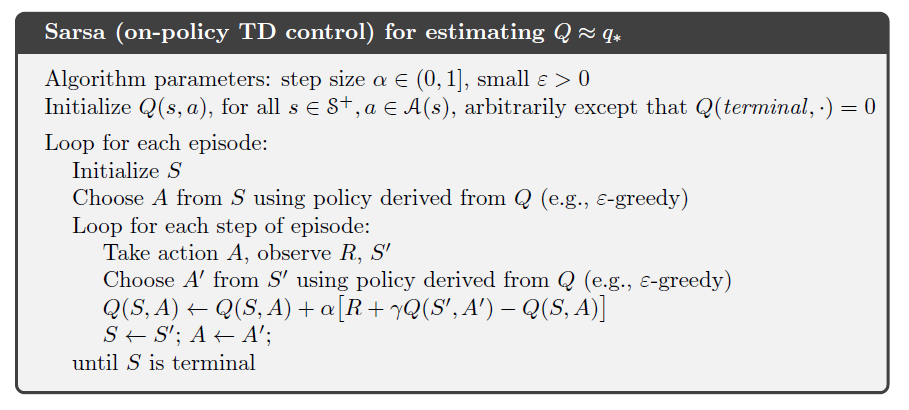


In [7]:
class SARSA_TDControl():
    def __init__(self, 
                 space_size, 
                 action_size, 
                 gamma=1, 
                 lr_v=0.01):
        """
        Calculates optimal policy using in-policy Temporal Difference control
        Evaluates Q-value for (S,A) pairs, using one-step updates.
        """        
        # the discount factor
        self.gamma = gamma
        # size of system
        self.space_size = space_size # as tuple
        self.action_size = action_size

        # the learning rate
        self.lr_v = lr_v
        
        # where to save returns
        self.Qvalues = np.zeros( (*self.space_size, self.action_size) )
    
    # -------------------   
    def single_step_update(self, s, a, r, new_s, new_a, done):
        """
        Uses a single step to update the values, using Temporal Difference for Q values.
        Employs the EXPERIENCED action in the new state  <- Q(S_new, A_new).
        """
        if done:
            
            
            # CODE HERE!
            # deltaQ = R - Q(s,a)
            
            deltaQ = (r + 0 - self.Qvalues[ (*s, a) ])
        else:
            
            # CODE HERE!
            # deltaQ = R + gamma*Q(new_s, new_a) - Q(s,a)
            
            deltaQ = (r + 
                      self.gamma * self.Qvalues[ (*new_s, new_a) ] 
                                 - self.Qvalues[ (*    s,     a) ])
            
        self.Qvalues[ (*s, a) ] += self.lr_v * deltaQ
        
    # ---------------------
    def get_action_epsilon_greedy(self, s, eps):
        """
        Chooses action at random using an epsilon-greedy policy wrt the current Q(s,a).
        """
        ran = np.random.rand()
        
        # CODE HERE!
        
        if (ran < eps):
            # probability is uniform for all actions!
            prob_actions = np.ones(self.action_size) / self.action_size 
        
        else:
            # I find the best Qvalue
            best_value = np.max(self.Qvalues[ (*s,) ])
            
            # There could be actions with equal value! 
            best_actions = ( self.Qvalues[ (*s,) ] == best_value )


            # best_actions is 
            # *True* if the value is equal to the best (possibly ties)
            # *False* if the action is suboptimal
            prob_actions = best_actions / np.sum(best_actions)
            
        # take one action from the array of actions with the probabilities as defined above.
        a = np.random.choice(self.action_size, p=prob_actions)
        return a 
        
    def greedy_policy(self):
        
        # CODE HERE!
        
        a = np.argmax(self.Qvalues, axis = 2)
        return a

Qvalues for action 0 = Down


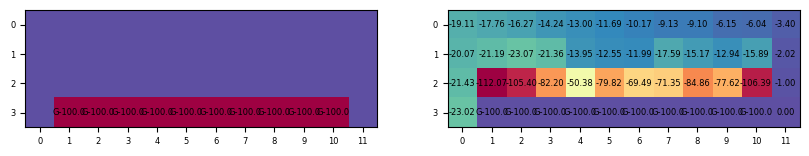

Qvalues for action 1 = Up


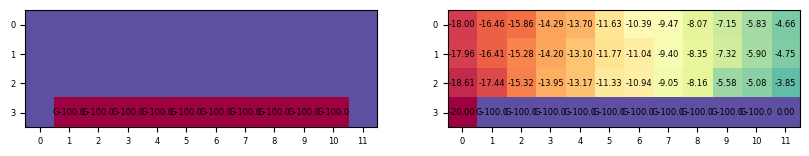

Qvalues for action 2 = Right


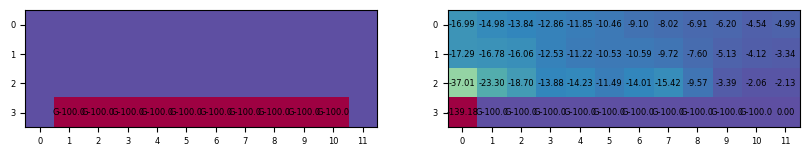

Qvalues for action 3 = Left


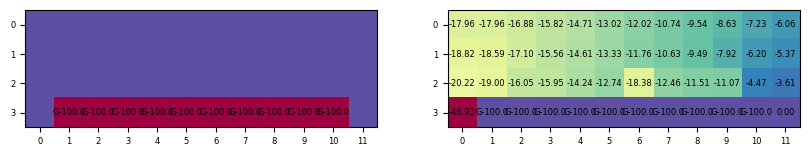

In [8]:
# TD(0) CONTROL: SARSA

n_episodes = 2000

# Initialize 
SARSA = SARSA_TDControl(space_size=World.shape, action_size=4, gamma=gamma, lr_v=0.15)
epsilon = 0.15

performance_traj_SARSA = np.zeros(n_episodes)

# RUN OVER EPISODES
for i in range(n_episodes):
    done = False

    env.reset()
    s = env.current_state
    a = SARSA.get_action_epsilon_greedy(s, epsilon)
    act = Actions[a]
    
    while not done:
    #for _ in range(100):
        # Evolve one step
        new_s, r, done = env.step(act)
        
        # Keeps track of performance for each episode
        performance_traj_SARSA[i] += r
        
        # Choose new action index
        new_a = SARSA.get_action_epsilon_greedy(new_s, epsilon)
        #print(s,act,a, r,new_s,new_a, done, ' Qvalue ', SARSA.Qvalues[(*s,)])
        # (Corresponding action to index)
        act = Actions[new_a]
        # Single update with (S, A, R', S', A')
        SARSA.single_step_update(s, a, r, new_s, new_a, done)
        
        a = new_a
        s = new_s


Qvalues = SARSA.Qvalues

print('Qvalues for action 0 = Down')
plot_world_values(World, Qvalues[:,:,0])
print('Qvalues for action 1 = Up')
plot_world_values(World, Qvalues[:,:,1])
print('Qvalues for action 2 = Right')
plot_world_values(World, Qvalues[:,:,2])
print('Qvalues for action 3 = Left')
plot_world_values(World, Qvalues[:,:,3])




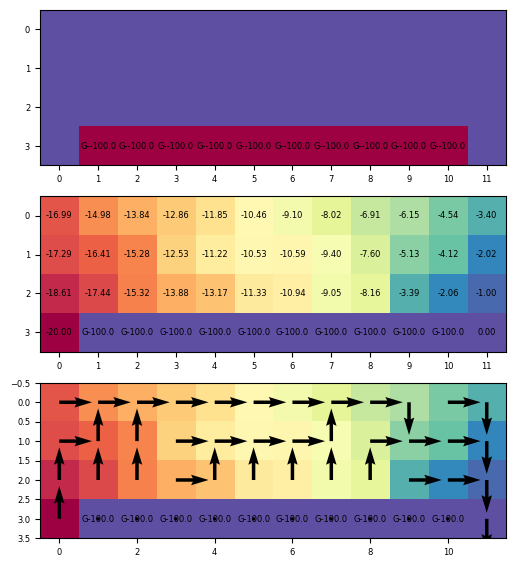

In [9]:
# Optimal policy for SARSA as index actions
optimal_policy_index = SARSA.greedy_policy()

# Optimal policy for SARSA as arrows for plots
optimal_policy_arrows = np.zeros( (*World.shape, 2) )
optimal_policy_arrows[:,:] = Actions[ optimal_policy_index ]

optimal_Qvalue_action = np.zeros((optimal_policy_index.shape))

Lx, Ly = World.shape

for i in range(Lx):
    for j in range(Ly):
        optimal_Qvalue_action[i,j] = Qvalues[i,j,optimal_policy_index[i,j]]


plot_world_values_policy(World, optimal_Qvalue_action, optimal_policy_arrows)


##  Q-Learning: off-policy TD Control

Q-Learning is a very straightforward method.
As a policy to explore, we will use an $\epsilon$-greedy function:

$$
    \pi_t^{\epsilon}(s) = \left\{
    \begin{array}{cll}
        & \text{argmax}_a Q_t(s, a)   & \text{if} \,\,\,\, w.p. 1-\epsilon\\[2ex]
        & \text{any}\,\,\, a   & \text{if} \,\,\,\, w.p. \epsilon \\[2ex]
    \end{array}
    \right.
$$

At every step $t$, we will store the new reward $R_{t+1}$ and the new state $S_{t+1}$ and calculated the update almost as in SARSA. The difference in TD Control is that instead of using the action $A_{t+1}$ which we really took, we evaluate the update using the **best (known) Q-value available in $S_{t+1}$**, as if we were following a greedy path:

$$
\delta Q = R_{t+1} + \gamma \,\, \max_a Q_t(S_{t+1}, a) - Q_t(S_{t}, A_t)
$$


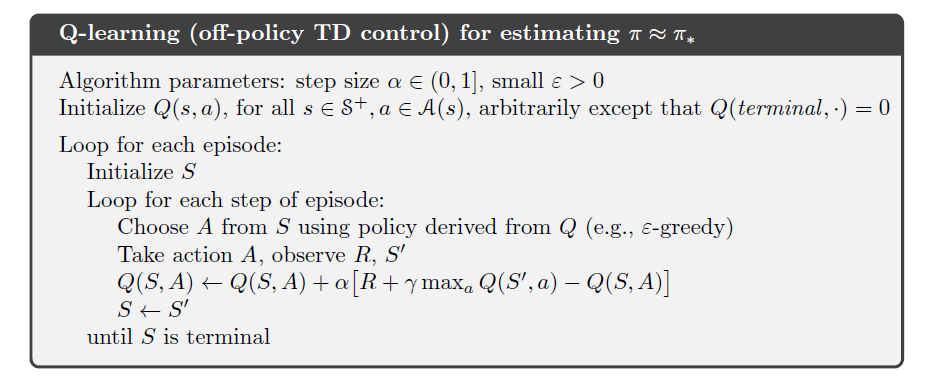

**Q:** Why is it _off_-policy?


In [10]:
class Qlearning_TDControl():
    def __init__(self, 
                 space_size, 
                 action_size, 
                 gamma=1, 
                 lr_v=0.01):
        """
        Calculates optimal policy using off-policy Temporal Difference control
        Evaluates Q-value for (S,A) pairs, using one-step updates.
        """            
        # the discount factor
        self.gamma = gamma
        # size of system
        self.space_size = space_size # as tuple
        self.action_size = action_size

        # the learning rate
        self.lr_v = lr_v
        
        # where to save returns
        self.Qvalues = np.zeros( (*self.space_size, self.action_size) )
    
    # -------------------   
    def single_step_update(self, s, a, r, new_s, done):
        """
        Uses a single step to update the values, using Temporal Difference for Q values.
        Uses the BEST (evaluated) action in the new state <- Q(S_new, A*) = max_A Q(S_new, A).
        """
        if done:
            
            # CODE HERE !
            # deltaQ = R - Q(s,a) 
            
            deltaQ = (r + 0 - self.Qvalues[ (*s, a) ])
        else:

            
            # CODE HERE!
            # deltaQ = R + gamma*max_act Q(new_s, act)- Q(s,a) 
            
            maxQ_over_actions = np.max(self.Qvalues[ (*new_s,) ])
            
            deltaQ = (r + 
                      self.gamma * maxQ_over_actions 
                                 - self.Qvalues[ (*s,a) ])
        
        self.Qvalues[ (*s, a) ] += self.lr_v * deltaQ
            
    # ---------------------
    def get_action_epsilon_greedy(self, s, eps):
        """
        Chooses action at random using an epsilon-greedy policy wrt the current Q(s,a).
        """
        
        # CODE HERE!
        # ... ACTUALLY, COPY AND PASTE FROM SARSA!
        
        ran = np.random.rand()
        
        if (ran < eps):
            # probability is uniform for all actions!
            prob_actions = np.ones(self.action_size) / self.action_size 
        
        else:
            # I find the best Qvalue
            best_value = np.max(self.Qvalues[ (*s,) ])
            
            # There could be actions with equal value! 
            best_actions = ( self.Qvalues[ (*s,) ] == best_value )


            # best_actions is 
            # *True* if the value is equal to the best (possibly ties)
            # *False* if the action is suboptimal
            prob_actions = best_actions / np.sum(best_actions)
            
        # take one action from the array of actions with the probabilities as defined above.
        a = np.random.choice(self.action_size, p=prob_actions)
        return a 
        
    def greedy_policy(self):
        
        # CODE HERE!
        # ... ACTUALLY, COPY AND PASTE FROM SARSA!
        
        a = np.argmax(self.Qvalues, axis = 2)
        return a

## Q-Learning Control

Qvalues for action 0 = Down


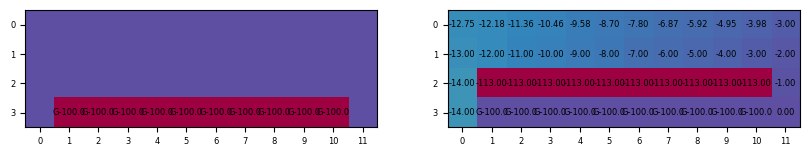

Qvalues for action 1 = Up


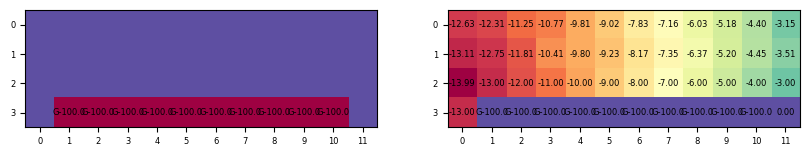

Qvalues for action 2 = Right


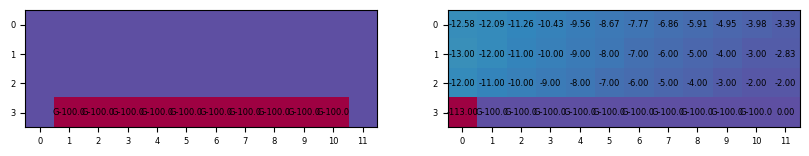

Qvalues for action 3 = Left


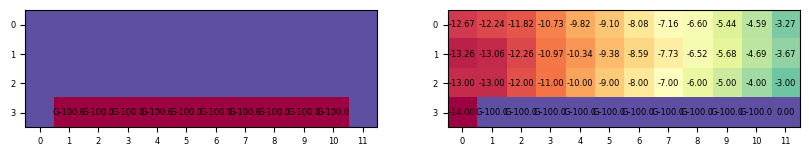

In [11]:
# Q-Learning Control

n_episodes = 2000

# Initialize 
QLearning = Qlearning_TDControl(space_size=World.shape, action_size=4, gamma=gamma, lr_v=0.15)
epsilon = 0.15


performance_traj_Q = np.zeros(n_episodes)

# RUN OVER EPISODES
for i in range(n_episodes):
    done = False

    env.reset()
    s = env.current_state
    a = QLearning.get_action_epsilon_greedy(s, epsilon)
    act = Actions[a]
    
    while not done:
    #for _ in range(100):
        # Evolve one step
        new_s, r, done = env.step(act)
        
        # Keeps track of performance for each episode
        performance_traj_Q[i] += r
        
        # Choose new action index
        new_a = QLearning.get_action_epsilon_greedy(new_s, epsilon)
        #print(s,act,a, r,new_s,new_a, done, ' Qvalue ', SARSA.Qvalues[(*s,)])
        # (Corresponding action to index)
        act = Actions[new_a]
        # Single update with (S, A, R', S')
        QLearning.single_step_update(s, a, r, new_s, done)
        
        a = new_a
        s = new_s


Qvalues_QLearning = QLearning.Qvalues

print('Qvalues for action 0 = Down')
plot_world_values(World, Qvalues_QLearning[:,:,0])
print('Qvalues for action 1 = Up')
plot_world_values(World, Qvalues_QLearning[:,:,1])
print('Qvalues for action 2 = Right')
plot_world_values(World, Qvalues_QLearning[:,:,2])
print('Qvalues for action 3 = Left')
plot_world_values(World, Qvalues_QLearning[:,:,3])


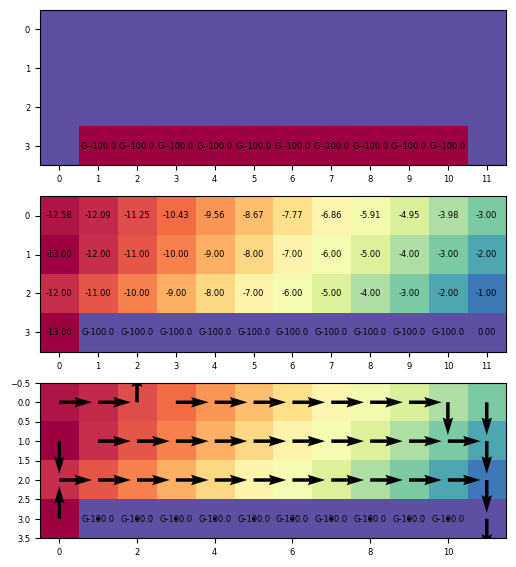

In [12]:
# Optimal policy for QLearning as index actions
optimal_policy_index_QLearning = QLearning.greedy_policy()

# Optimal policy for QLearning as arrows for plots
optimal_policy_arrows_QLearning = np.zeros( (*World.shape, 2) )
optimal_policy_arrows_QLearning[:,:] = Actions[ optimal_policy_index_QLearning ]

optimal_Qvalue_action_QLearning = np.zeros((optimal_policy_index_QLearning.shape))

Lx, Ly = World.shape

for i in range(Lx):
    for j in range(Ly):
        optimal_Qvalue_action_QLearning[i,j] = Qvalues_QLearning[i,j,optimal_policy_index_QLearning[i,j]]


plot_world_values_policy(World, optimal_Qvalue_action_QLearning, optimal_policy_arrows_QLearning)

## Running performance

Let us compare the running performances (rewards during learning) and optimal policies.

        

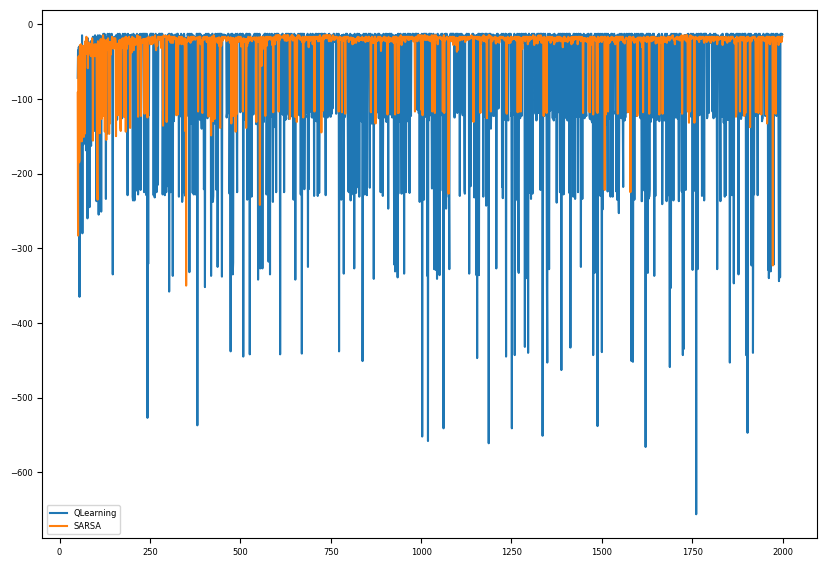

In [13]:
fig, ax = plt.subplots()  # Create a figure and an axes.
ax.plot(np.arange(50, n_episodes), performance_traj_Q[50:], label='QLearning')
ax.plot(np.arange(50, n_episodes), performance_traj_SARSA[50:], label='SARSA')
ax.legend()



## **Question:** 
- Q-Learning seems to have found the optimal policy while SARSA hasn't..
- ... But average performance of SARSA is better!

Why? What is the difference between them?


## Expected SARSA

Expected SARSA is a very simple modification to the SARSA method. 
It helps reducing the variance of SARSA, since it averages over _all possible actions in the new state $S_{t+1}$_ weighted by the policy.

Its only chance is in the update for the evaluation of the $Q$-value. Given the immediately past experience, the TD(0) error $\delta_Q$ is constructed with:

- the past state $S_t$
- the past action $A_t$
- the new reward $R_{t+1}$ 
- the new state $S_{t+1}$ 
- ~the new action (following the $\epsilon$-greedy policy)~
- All possible actions in $S_{t+1}$ weighted by the $\epsilon$-greedy policy.

($\rightarrow$ ExpectedSARSA, since instead of the new A we use an expectation value)

and will calculated the update as a Temporal Difference error TD(0).

$$
\delta_Q = R_{t+1} + \gamma \,\, \sum_a \pi_t(a | S_{t+1}) \,\, \hat{Q}_t(S_{t+1}, a) - \hat{Q}_t(S_{t}, A_t)
$$

(Compare it with SARSA where we had : $
\delta_Q = R_{t+1} + \gamma \,\, \hat{Q}_t(S_{t+1}, A_{t+1}) - \hat{Q}_t(S_{t}, A_t)
$)

Then the update will be:

$$
\hat{Q}_{t+1} = \hat{Q}_t + \alpha \delta_Q
$$



In [14]:
class EXPECTED_SARSA_TDControl():
    def __init__(self, space_size, action_size, gamma=1, lr_v=0.01):
        """
        Calculates optimal policy using in-policy Temporal Difference control
        Evaluates Q-value for (S,A) pairs, using one-step updates.
        """        
        # the discount factor
        self.gamma = gamma
        # size of system
        self.space_size = space_size 
        self.action_size = action_size

        # the learning rate
        self.lr_v = lr_v
        
        # where to save returns
        self.Qvalues = np.zeros( (*self.space_size, self.action_size) )
    
    # -------------------   
    def single_step_update(self, s, a, r, new_s, done, eps):
        """
        Uses a single step to update the values, using Temporal Difference for Q values.
        Employs the EXPERIENCED action in the new state  <- Q(S_new, A_new).
        """
        if done:
            
            # CODE HERE!
            #deltaQ =  R - Q(s,a)
            
            deltaQ = (r + 0 - self.Qvalues[ (*s, a) ])
        else:
            
            # CODE HERE!
            #deltaQ =  R + sum_b pi(b, new_s) Q(new_s, b) - Q(s,a)
            
            deltaQ = (r + 
                      self.gamma * np.dot( self.Qvalues[ (*new_s,)], self.policy(new_s, eps)) 
                                                                      - self.Qvalues[(*s,a)])
        self.Qvalues[(*s,a) ] += self.lr_v * deltaQ
        
       
    # ---------------------
    def get_action_epsilon_greedy(self, s, eps):
        """
        Chooses action at random using an epsilon-greedy policy wrt the current Q(s,a).
        """
        
                
        # CODE HERE!
        # ... ACTUALLY, COPY AND PASTE FROM SARSA!
        
        ran = np.random.rand()
        
        if (ran < eps):
            # probability is uniform for all actions!
            prob_actions = np.ones(self.action_size) / self.action_size 
        
        else:
            # I find the best Qvalue
            best_value = np.max(self.Qvalues[ (*s,) ])
            
            # There could be actions with equal value! 
            best_actions = ( self.Qvalues[ (*s,) ] == best_value )


            # best_actions is 
            # *True* if the value is equal to the best (possibly ties)
            # *False* if the action is suboptimal
            prob_actions = best_actions / np.sum(best_actions)
            
        # take one action from the array of actions with the probabilities as defined above.
        a = np.random.choice(self.action_size, p=prob_actions)
        return a 
        
    def greedy_policy(self):
        """
        Calculates the greedy policy given current Qvalues.
        """
        greedy_pol = np.argmax(self.Qvalues, axis = 2)
        return greedy_pol
        
    def policy(self, s, eps):
        """
        Probabilities from an epsilon-greedy policy wrt the current Q(s,a).
        """
        # Uniform (epsilon) probability for all actions...
        policy = np.ones(self.action_size) / self.action_size * eps 
        # ... plus 1-epsilon probabilities for best actions:
        # First I find the best values
        best_value = np.max(self.Qvalues[ (*s,) ])
        # There could be actions with equal value! 
        # This mask is 1 if the value is equal to the best (tie)
        # or 0 if the action is suboptimal
        best_actions = (self.Qvalues[ (*s,) ] == best_value)
        policy += best_actions / np.sum(best_actions) * (1 - eps)
        return policy


Qvalues for action 0 = Down


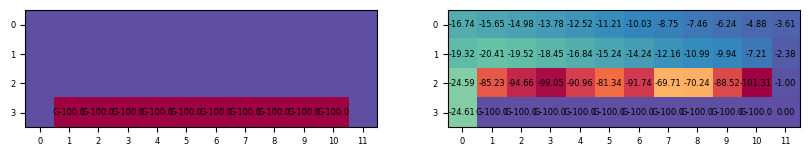

Qvalues for action 1 = Up


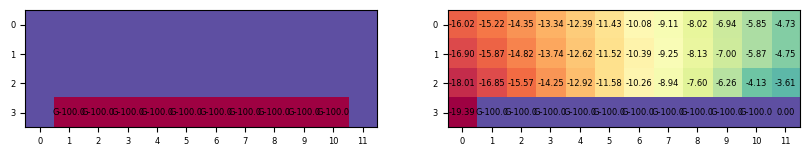

Qvalues for action 2 = Right


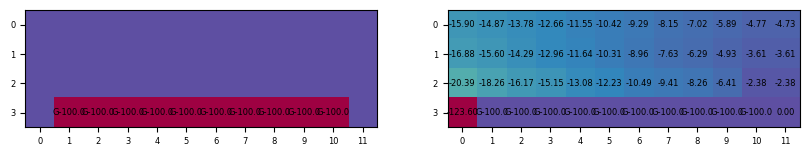

Qvalues for action 3 = Left


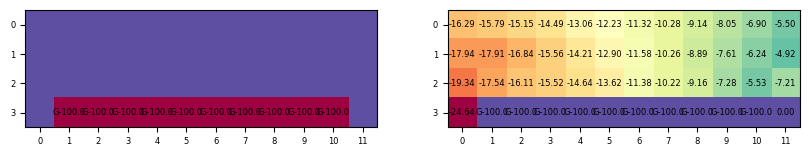

In [15]:
# Expected SARSA Control

n_episodes = 2000

# Initialize 
ExpSARSA = EXPECTED_SARSA_TDControl(space_size=World.shape, action_size=4, gamma=gamma, lr_v=0.15)
epsilon = 0.15


performance_traj_ExpSARSA = np.zeros(n_episodes)

# RUN OVER EPISODES
for i in range(n_episodes):
    done = False

    env.reset()
    s = env.current_state
    a = ExpSARSA.get_action_epsilon_greedy(s, epsilon)
    act = Actions[a]
    
    while not done:
    #for _ in range(100):
        # Evolve one step
        new_s, r, done = env.step(act)
        
        # Keeps track of performance for each episode
        performance_traj_ExpSARSA[i] += r
        
        # Choose new action index
        new_a = ExpSARSA.get_action_epsilon_greedy(new_s, epsilon)
        # (Corresponding action to index)
        act = Actions[new_a]
        # Single update with (S, A, R', S')
        ExpSARSA.single_step_update(s, a, r, new_s, done, epsilon)
        
        a = new_a
        s = new_s


Qvalues_ExpSARSA = ExpSARSA.Qvalues

print('Qvalues for action 0 = Down')
plot_world_values(World, Qvalues_ExpSARSA[:,:,0])
print('Qvalues for action 1 = Up')
plot_world_values(World, Qvalues_ExpSARSA[:,:,1])
print('Qvalues for action 2 = Right')
plot_world_values(World, Qvalues_ExpSARSA[:,:,2])
print('Qvalues for action 3 = Left')
plot_world_values(World, Qvalues_ExpSARSA[:,:,3])


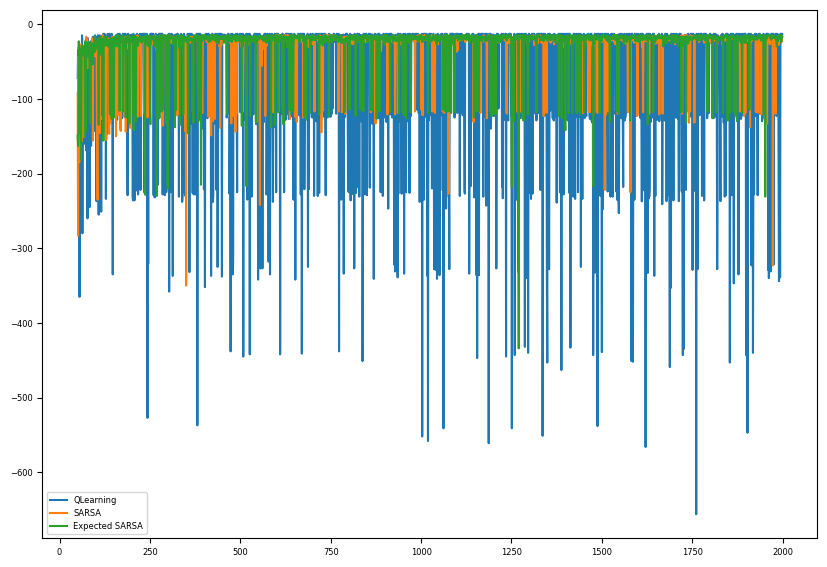

In [16]:
fig, ax = plt.subplots()  # Create a figure and an axes.
ax.plot(np.arange(50, n_episodes), performance_traj_Q[50:], label='QLearning')
ax.plot(np.arange(50, n_episodes), performance_traj_SARSA[50:], label='SARSA')
ax.plot(np.arange(50, n_episodes), performance_traj_ExpSARSA[50:], label='Expected SARSA')

ax.legend()

## Last but not least: Convergence

We used so far two constant values:

- Constant learning rate $\alpha$. **BAD!** The values $Q$ will never converge, but instead oscillate forever around the "true" value.

_Solution_: Implement $\alpha_t$ such that $i)$ $\sum_t^{\infty} \alpha_t^2$ converges, $ii)$  $\sum_t^{\infty} \alpha_t$ diverges. 
Let us use a constant $\alpha$ up to some point $t^*$, and then let us decrease it as $\alpha_t \sim 1/(1 + k (t-t^*)^{0.75})$


- Constant $\epsilon$ for $\epsilon$-greedy policies. **BAD!** The policies may be consistently sub-optimal (as SARSA).

_Solution_: Let us use a constant $\epsilon$ up to some point $t^*$, and then $\epsilon_t \sim 1/(1+k (t-t^*)^{1.05})$

Let us see how fast this changes are.

**Q:** Why not decay from start?

Qvalues for action 0 = Down


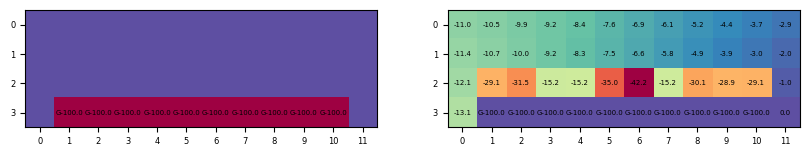

Qvalues for action 1 = Up


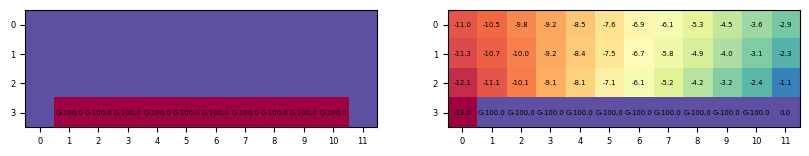

Qvalues for action 2 = Right


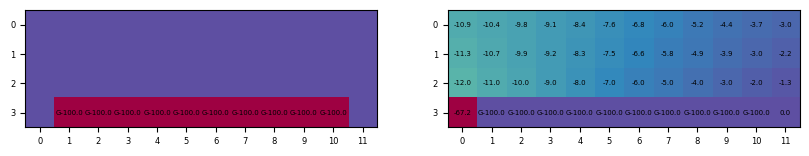

Qvalues for action 3 = Left


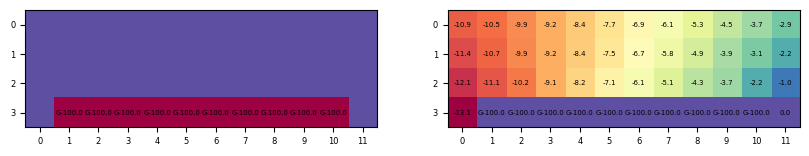

(-120.0, -10.0)

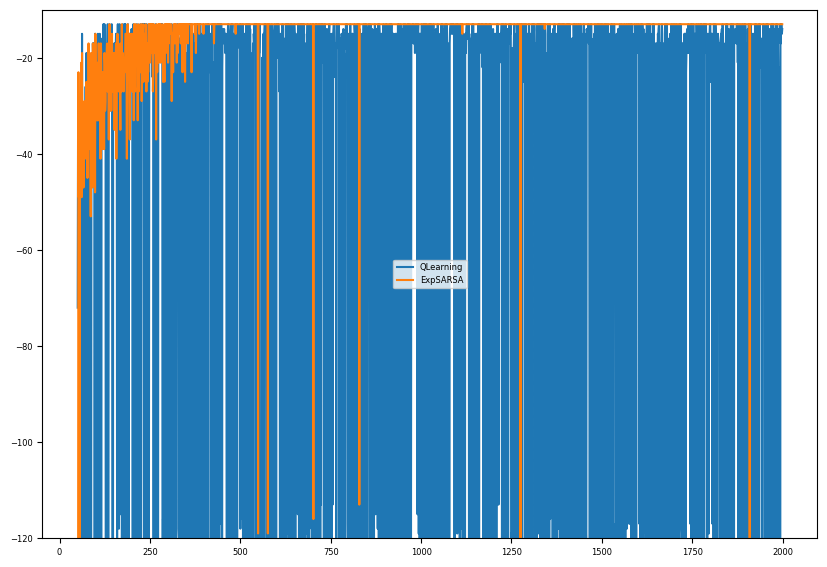

In [32]:
# TD(0) CONTROL: SARSA

n_episodes = 2000

# Initialize 
epsilon_0 = 0.05
lr_v_0 = 0.15

ExpSARSA = EXPECTED_SARSA_TDControl(space_size=World.shape, action_size=4, gamma=gamma, lr_v=lr_v_0)

performance_traj_ExpSARSA_conv = np.zeros(n_episodes)

count = 0
tstar = 5000


epsilon = epsilon_0

# RUN OVER EPISODES
for i in range(n_episodes):
    done = False

    env.reset()
    s = env.current_state
    a = ExpSARSA.get_action_epsilon_greedy(s, epsilon)
    act = Actions[a]
    
    while not done:
    #for _ in range(100):
        
        count += 1
        
        # Evolve one step
        new_s, r, done = env.step(act)
        
        # Keeps track of performance for each episode
        performance_traj_ExpSARSA_conv[i] += r
        
        # Choose new action index
        new_a = ExpSARSA.get_action_epsilon_greedy(new_s, epsilon)
        #print(s,act,a, r,new_s,new_a, done, ' Qvalue ', SARSA.Qvalues[(*s,)])
        # (Corresponding action to index)
        act = Actions[new_a]
        # Single update with (S, A, R', S', A')
        ExpSARSA.single_step_update(s, a, r, new_s, done, epsilon)
        
        if count > tstar:
            # UPDATE OF LEARNING
            ExpSARSA.lr_v = lr_v_0/(1 + 0.003*(count - tstar)**0.75)
            # UPDATE OF EPSILON
            epsilon = epsilon_0/(1. + 0.005*(count - tstar)**1.05)
        
        
        a = new_a
        s = new_s


Qvalues_ExpSARSA_conv = ExpSARSA.Qvalues

print('Qvalues for action 0 = Down')
plot_world_values(World, Qvalues_ExpSARSA_conv[:,:,0])
print('Qvalues for action 1 = Up')
plot_world_values(World, Qvalues_ExpSARSA_conv[:,:,1])
print('Qvalues for action 2 = Right')
plot_world_values(World, Qvalues_ExpSARSA_conv[:,:,2])
print('Qvalues for action 3 = Left')
plot_world_values(World, Qvalues_ExpSARSA_conv[:,:,3])




fig, ax = plt.subplots()  # Create a figure and an axes.
ax.plot(np.arange(50, n_episodes), performance_traj_Q[50:], label='QLearning')
ax.plot(np.arange(50, n_episodes), performance_traj_ExpSARSA_conv[50:], label='ExpSARSA')
ax.legend()
ax.set_ylim(-120,-10)


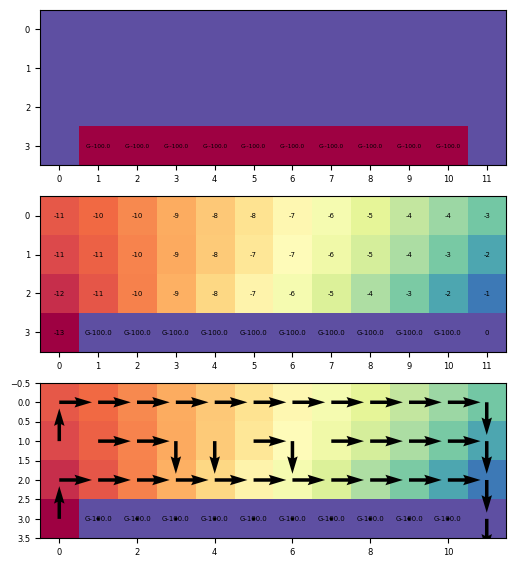

In [31]:
# Optimal policy for QLearning as index actions
optimal_policy_index_ExpSARSA_conv = ExpSARSA.greedy_policy()

# Optimal policy for QLearning as arrows for plots
optimal_policy_arrows_ExpSARSA_conv = np.zeros( (*World.shape, 2) )
optimal_policy_arrows_ExpSARSA_conv[:,:] = Actions[ optimal_policy_index_ExpSARSA_conv ]

optimal_Qvalue_action_ExpSARSA_conv = np.zeros((optimal_policy_index_ExpSARSA_conv.shape))

Lx, Ly = World.shape

for i in range(Lx):
    for j in range(Ly):
        optimal_Qvalue_action_ExpSARSA_conv[i,j] = Qvalues_ExpSARSA_conv[i,j,optimal_policy_index_ExpSARSA_conv[i,j]]


plot_world_values_policy(World, optimal_Qvalue_action_ExpSARSA_conv, optimal_policy_arrows_ExpSARSA_conv)

## ----------------------------END-----------------------
## Below there is just an utility plot function...

In [30]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np

plt.rcParams['figure.figsize'] = [10, 7]
plt.rcParams['figure.dpi'] = 100 
plt.rcParams['font.size'] = 6

def plot_world(World):
    # ------------------
    Ly, Lx = World.shape

    fig, ax = plt.subplots()
    im = ax.imshow(World, cmap=plt.get_cmap("Spectral"))
    
    # We want to show all ticks...
    ax.set_xticks(np.arange(Lx))
    ax.set_yticks(np.arange(Ly))

    goal = np.where(np.logical_or( World > 0.0, World < -1.0))
    blocks = np.where(World == -1.0)
    # Loop over data dimensions and create text annotations.
    for i in range(Lx):
        for j in range(Ly):
            if np.logical_and(goal[0]==j,goal[1]==i).any():
                text = ax.text(i,j, 'G{}'.format(int(World[j,i])), ha="center", va="center", color="black")
            elif np.logical_and(blocks[0]==j,blocks[1]==i).any():
                 text = ax.text(i,j, 'X', ha="center", va="center", color="black", backgroundcolor="black")
            else:
                pass
    plt.show()
    # -------------------

    

def plot_world_values(World, Values):
    # ------------------
    Ly, Lx = World.shape

    fig, (ax, ax2) = plt.subplots(1,2)
    im = ax.imshow(World, cmap=plt.get_cmap("Spectral"))

    # We want to show all ticks...
    ax.set_xticks(np.arange(Lx))
    ax.set_yticks(np.arange(Ly))

    goal = np.where(np.logical_or( World > 0.0, World < -1.0))
    blocks = np.where(World == -1.0)
    # Loop over data dimensions and create text annotations.
    for i in range(Lx):
        for j in range(Ly):
            if np.logical_and(goal[0]==j,goal[1]==i).any():
                text = ax.text(i,j, 'G{}'.format(World[j,i]), ha="center", va="center", color="black", fontsize="small")
            elif np.logical_and(blocks[0]==j,blocks[1]==i).any():
                text = ax.text(i,j, 'X', ha="center", va="center", color="black", backgroundcolor="black")
            else:
                pass

    im2 = ax2.imshow(Values, cmap=plt.get_cmap("Spectral"))

    # We want to show all ticks...
    ax2.set_xticks(np.arange(Lx))
    ax2.set_yticks(np.arange(Ly))

    # Loop over data dimensions and create text annotations.
    for i in range(Lx):
        for j in range(Ly):
            if np.logical_and(goal[0]==j, goal[1]==i).any():
                text = ax2.text(i,j, 'G{}'.format(World[j,i]), ha="center", va="center", color="black", fontsize="small")
            elif np.logical_and(blocks[0]==j,blocks[1]==i).any():
                text = ax2.text(i,j, 'X', ha="center", va="center", color="black", backgroundcolor="black")
            else:
                text = ax2.text(i, j, '{:.1f}'.format(Values[j, i]), ha="center", va="center", color="black", fontsize="small")
                
                
    plt.show()
    # -------------------

    

def plot_world_values_policy(World, Values, Policy):
    # ------------------
    Ly, Lx = World.shape

    fig, ((ax), (ax2), (ax3)) = plt.subplots(3,1)
    im = ax.imshow(World, cmap=plt.get_cmap("Spectral"))

    # We want to show all ticks...
    ax.set_xticks(np.arange(Lx))
    ax.set_yticks(np.arange(Ly))

    goal = np.where(np.logical_or( World > 0.0, World < -1.0))
    blocks = np.where(World == -1.0)
    # Loop over data dimensions and create text annotations.
    for i in range(Lx):
        for j in range(Ly):
            if np.logical_and(goal[0]==j,goal[1]==i).any():
                text = ax.text(i,j, 'G-{}'.format(World[j,i]), ha="center", va="center", color="black", fontsize="x-small")
            elif np.logical_and(blocks[0]==j,blocks[1]==i).any():
                text = ax.text(i,j, 'X', ha="center", va="center", color="black", backgroundcolor="black")
            else:
                pass

    im2 = ax2.imshow(Values, cmap=plt.get_cmap("Spectral"))

    # We want to show all ticks...
    ax2.set_xticks(np.arange(Lx))
    ax2.set_yticks(np.arange(Ly))

    # Loop over data dimensions and create text annotations.
    for i in range(Lx):
        for j in range(Ly):
            if np.logical_and(goal[0]==j, goal[1]==i).any():
                text = ax2.text(i,j, 'G{}'.format(World[j,i]), ha="center", va="center", color="black", fontsize="small")
                text = ax3.text(i,j, 'G{}'.format(World[j,i]), ha="center", va="center", color="black", fontsize="small")
            elif np.logical_and(blocks[0]==j,blocks[1]==i).any():
                text = ax2.text(i,j, 'X', ha="center", va="center", color="black", backgroundcolor="black")
                text = ax3.text(i,j, 'X', ha="center", va="center", color="black", backgroundcolor="black")
            else:
                text = ax2.text(i, j, '{:.0f}'.format(Values[j, i]), ha="center", va="center", color="black", fontsize="small")
    
    im3 = ax3.imshow(Values, cmap=plt.get_cmap("Spectral"))
    X = np.arange(Lx)
    Y = np.arange(Ly)

    for gx, gy in zip(goal[0],goal[1]) :
        Policy[gx,gy] = 0
        
    U, V = Policy[:,:,1], -Policy[:,:,0]
    q = ax3.quiver(X, Y, U, V, color="black")

    plt.show()
    # -------------------
    